In [2]:
%cd ../..

C:\Users\ManuJoseph\OneDrive - Thoucentric\Work\Projects\Playground\AdvancedTimeSeriesForecastingBook\Github\Modern-Time-Series-Forecasting-with-Python-


In [3]:
import os
import time
import shutil

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import joblib
pio.templates.default = "plotly_white"

import warnings
from pathlib import Path

import humanize
from darts.metrics import mae, mase, mse
from sklearn.preprocessing import StandardScaler
from src.forecasting.ml_forecasting import (
    FeatureConfig,
    MissingValueConfig,
    MLForecast,
    ModelConfig,
    calculate_metrics,
)
from src.utils import plotting_utils
from src.utils.general import LogTime
from src.utils.ts_utils import darts_metrics_adapter, forecast_bias
from tqdm.autonotebook import tqdm
from src.forecasting.ml_forecasting import calculate_metrics
from src.utils import ts_utils
from IPython.display import display, HTML
# %load_ext autoreload
# %autoreload 2
np.random.seed(42)
tqdm.pandas()

C:\Users\ManuJoseph\OneDrive - Thoucentric\Work\Projects\Playground\AdvancedTimeSeriesForecastingBook\Github\Modern-Time-Series-Forecasting-with-Python-\src\utils\data_utils.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
os.makedirs("imgs/chapter_12", exist_ok=True)
preprocessed = Path("data/london_smart_meters/preprocessed")
output = Path("data/london_smart_meters/output")

## Utility Functions

In [4]:
def format_plot(fig, legends=None, xlabel="Time", ylabel="Value", title="", font_size=15):
    if legends:
        names = cycle(legends)
        fig.for_each_trace(lambda t: t.update(name=next(names)))
    fig.update_layout(
        autosize=False,
        width=900,
        height=500,
        title_text=title,
        title={"x": 0.5, "xanchor": "center", "yanchor": "top"},
        titlefont={"size": 20},
        legend_title=None,
        legend=dict(
            font=dict(size=font_size),
            orientation="h",
            yanchor="bottom",
            y=0.98,
            xanchor="right",
            x=1,
        ),
        yaxis=dict(
            title_text=ylabel,
            titlefont=dict(size=font_size),
            tickfont=dict(size=font_size),
        ),
        xaxis=dict(
            title_text=xlabel,
            titlefont=dict(size=font_size),
            tickfont=dict(size=font_size),
        )
    )
    return fig

In [5]:
def evaluate_forecast(y_pred, test_target, train_target, model_name):
    metric_l = []
    for _id in tqdm(test_target.index.get_level_values(0).remove_unused_categories().categories, desc="Calculating metrics..."):
        target = test_target.xs(_id)
        _y_pred = y_pred.xs(_id)
        history = train_target.xs(_id)
        metric_l.append(
            calculate_metrics(target, _y_pred, name=model_name, y_train=history)
        )
    eval_metrics_df = pd.DataFrame(metric_l)
    agg_metrics = {
            "Algorithm": model_name,
            "MAE": ts_utils.mae(
                test_target, y_pred
            ),
            "MSE": ts_utils.mse(
                test_target, y_pred
            ),
            "meanMASE": eval_metrics_df.loc[:, "MASE"].mean(),
            "Forecast Bias": ts_utils.forecast_bias_aggregate(
                test_target, y_pred
            )
    }
    return agg_metrics, eval_metrics_df

In [6]:
from itertools import cycle


def plot_forecast(pred_df, forecast_columns, forecast_display_names=None):
    if forecast_display_names is None:
        forecast_display_names = forecast_columns
    else:
        assert len(forecast_columns) == len(forecast_display_names)
    mask = ~pred_df[forecast_columns[0]].isnull()
    colors = [
        "rgba(" + ",".join([str(c) for c in plotting_utils.hex_to_rgb(c)]) + ",<alpha>)"
        for c in px.colors.qualitative.Plotly
    ]
    act_color = colors[0]
    colors = cycle(colors[1:])
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x=pred_df[mask].index,
            y=pred_df[mask].energy_consumption,
            mode="lines",
            line=dict(color=act_color.replace("<alpha>", "0.9")),
            name="Actual Consumption",
        )
    )
    for col, display_col in zip(forecast_columns, forecast_display_names):
        fig.add_trace(
            go.Scatter(
                x=pred_df[mask].index,
                y=pred_df.loc[mask, col],
                mode="lines",
                line=dict(dash="dot", color=next(colors).replace("<alpha>", "1")),
                name=display_col,
            )
        )
    return fig

def highlight_abs_min(s, props=''):
    return np.where(s == np.nanmin(np.abs(s.values)), props, '')

## Reading the data

In [7]:
try:
    #Reading the missing value imputed and train test split data
    train_df = pd.read_parquet(preprocessed/"selected_blocks_train_missing_imputed_feature_engg.parquet")
    # Read in the Validation dataset as test_df so that we predict on it
    test_df = pd.read_parquet(preprocessed/"selected_blocks_val_missing_imputed_feature_engg.parquet")
    # test_df = pd.read_parquet(preprocessed/"block_0-7_test_missing_imputed_feature_engg.parquet")
except FileNotFoundError:
    display(HTML("""
    <div class="alert alert-block alert-warning">
    <b>Warning!</b> File not found. Please make sure you have run 01-Feature Engineering.ipynb in Chapter06
    </div>
    """))

Selecting only half the blocks to make deep learning training smoother, faster and fit in GPU memory. This is purely a hardware constraint and done beacause dealing with the engineering challenges of handling huge datasets is out of scope for this book.

In [8]:
uniq_blocks = train_df.file.unique().tolist()
sel_blocks = sorted(uniq_blocks, key=lambda x: int(x.replace("block_","")))[:len(uniq_blocks)//2]
train_df = train_df.loc[train_df.file.isin(sel_blocks)]
test_df = test_df.loc[test_df.file.isin(sel_blocks)]
sel_lclids = train_df.LCLid.unique().tolist()

In [9]:
target = "energy_consumption"
index_cols = ["LCLid", "timestamp"]

In [10]:
# Setting the indices
train_df.set_index(index_cols, inplace=True, drop=False)
test_df.set_index(index_cols, inplace=True, drop=False)
# Creating a pred_df with actuals
pred_df = pd.concat([train_df[[target]], test_df[[target]]])

### Loading the GFM Forecast and calculating the aggregate metrics on selected LCLids

In [11]:
try:
    global_ml_fc_df = pd.read_pickle(output/"gfm_predictions_val_df.pkl")
    global_ml_fc_df = global_ml_fc_df.loc[global_ml_fc_df.index.get_level_values(0).isin(sel_lclids)]

    baseline_agg_metrics, baseline_metrics_df = evaluate_forecast(y_pred=global_ml_fc_df["GFM+Meta  (NativeLGBM)"], 
                                                     test_target = global_ml_fc_df["energy_consumption"], train_target = train_df["energy_consumption"], model_name="GFM+Meta  (NativeLGBM)")
except FileNotFoundError:
    display(HTML("""
    <div class="alert alert-block alert-warning">
    <b>Warning!</b> File not found. Please make sure you have run 01-Global Forecasting Models-ML.ipynb in Chapter10
    </div>
    """))

Calculating metrics...:   0%|          | 0/69 [00:00<?, ?it/s]

# Missing Value Handling

## Null check

In [12]:
nc = train_df.isnull().sum()
nc[nc>0]

pressure                                           1450
energy_consumption_lag_1                             69
energy_consumption_lag_2                            138
energy_consumption_lag_3                            207
energy_consumption_lag_4                            276
energy_consumption_lag_5                            345
energy_consumption_lag_46                          3174
energy_consumption_lag_47                          3243
energy_consumption_lag_48                          3312
energy_consumption_lag_49                          3381
energy_consumption_lag_50                          3450
energy_consumption_lag_334                        23046
energy_consumption_lag_335                        23115
energy_consumption_lag_336                        23184
energy_consumption_lag_337                        23253
energy_consumption_lag_338                        23322
energy_consumption_rolling_3_mean                   207
energy_consumption_rolling_3_std                

In [13]:
missing_value_config = MissingValueConfig(
    bfill_columns=[
        "energy_consumption_lag_1",
        "energy_consumption_lag_2",
        "energy_consumption_lag_3",
        "energy_consumption_lag_4",
        "energy_consumption_lag_5",
        "energy_consumption_lag_46",
        "energy_consumption_lag_47",
        "energy_consumption_lag_48",
        "energy_consumption_lag_49",
        "energy_consumption_lag_50",
        "energy_consumption_lag_334",
        "energy_consumption_lag_335",
        "energy_consumption_lag_336",
        "energy_consumption_lag_337",
        "energy_consumption_lag_338",
        "energy_consumption_rolling_3_mean",
        "energy_consumption_rolling_3_std",
        "energy_consumption_rolling_6_mean",
        "energy_consumption_rolling_6_std",
        "energy_consumption_rolling_12_mean",
        "energy_consumption_rolling_12_std",
        "energy_consumption_rolling_48_mean",
        "energy_consumption_rolling_48_std",
        "energy_consumption_48_seasonal_rolling_3_mean",
        "energy_consumption_48_seasonal_rolling_3_std",
        "energy_consumption_336_seasonal_rolling_3_mean",
        "energy_consumption_336_seasonal_rolling_3_std",
        "energy_consumption_ewma__span_2880",
        "energy_consumption_ewma__span_336",
        "energy_consumption_ewma__span_48",
    ],
    ffill_columns=[],
    zero_fill_columns=[],
)

In [14]:
train_df = missing_value_config.impute_missing_values(train_df)
test_df = missing_value_config.impute_missing_values(test_df)

In [15]:
nc = train_df.isnull().sum()
nc[nc>0]

Series([], dtype: int64)

# Running DL Global models

In [16]:
metric_record = [baseline_agg_metrics]

## PyTorch Tabular

In [17]:
from pytorch_tabular import TabularModel
from pytorch_tabular.models import FTTransformerConfig
from pytorch_tabular.config import DataConfig, OptimizerConfig, TrainerConfig, ExperimentConfig

In [18]:
data_config = DataConfig(
    target=[target], #target should always be a list. Multi-targets are only supported for regression. Multi-Task Classification is not implemented
    continuous_cols=[
        "visibility",
        "windBearing",
        "temperature",
        "dewPoint",
        "pressure",
        "apparentTemperature",
        "windSpeed",
        "humidity",
        "energy_consumption_lag_1",
        "energy_consumption_lag_2",
        "energy_consumption_lag_3",
        "energy_consumption_lag_4",
        "energy_consumption_lag_5",
        "energy_consumption_lag_46",
        "energy_consumption_lag_47",
        "energy_consumption_lag_48",
        "energy_consumption_lag_49",
        "energy_consumption_lag_50",
        "energy_consumption_lag_334",
        "energy_consumption_lag_335",
        "energy_consumption_lag_336",
        "energy_consumption_lag_337",
        "energy_consumption_lag_338",
        "energy_consumption_rolling_3_mean",
        "energy_consumption_rolling_3_std",
        "energy_consumption_rolling_6_mean",
        "energy_consumption_rolling_6_std",
        "energy_consumption_rolling_12_mean",
        "energy_consumption_rolling_12_std",
        "energy_consumption_rolling_48_mean",
        "energy_consumption_rolling_48_std",
        "energy_consumption_48_seasonal_rolling_3_mean",
        "energy_consumption_48_seasonal_rolling_3_std",
        "energy_consumption_336_seasonal_rolling_3_mean",
        "energy_consumption_336_seasonal_rolling_3_std",
        "energy_consumption_ewma_span_2880",
        "energy_consumption_ewma_span_336",
        "energy_consumption_ewma_span_48",
        "timestamp_Elapsed",
        "timestamp_Month_sin_1",
        "timestamp_Month_sin_2",
        "timestamp_Month_sin_3",
        "timestamp_Month_sin_4",
        "timestamp_Month_sin_5",
        "timestamp_Month_cos_1",
        "timestamp_Month_cos_2",
        "timestamp_Month_cos_3",
        "timestamp_Month_cos_4",
        "timestamp_Month_cos_5",
        "timestamp_Hour_sin_1",
        "timestamp_Hour_sin_2",
        "timestamp_Hour_sin_3",
        "timestamp_Hour_sin_4",
        "timestamp_Hour_sin_5",
        "timestamp_Hour_cos_1",
        "timestamp_Hour_cos_2",
        "timestamp_Hour_cos_3",
        "timestamp_Hour_cos_4",
        "timestamp_Hour_cos_5",
        "timestamp_Minute_sin_1",
        "timestamp_Minute_sin_2",
        "timestamp_Minute_sin_3",
        "timestamp_Minute_sin_4",
        "timestamp_Minute_sin_5",
        "timestamp_Minute_cos_1",
        "timestamp_Minute_cos_2",
        "timestamp_Minute_cos_3",
        "timestamp_Minute_cos_4",
        "timestamp_Minute_cos_5",
        "timestamp_Is_quarter_end",
        "timestamp_Is_quarter_start",
        "timestamp_Is_year_end",
        "timestamp_Is_year_start",
        "timestamp_Is_month_start",
    ],
    categorical_cols=[
        "holidays",
        "precipType",
        "icon",
        "summary",
        "timestamp_Month",
        "timestamp_Quarter",
        "timestamp_WeekDay",
        "timestamp_Dayofweek",
        "timestamp_Dayofyear",
        "timestamp_Hour",
        "timestamp_Minute",
        "stdorToU", 
        "Acorn", 
        "Acorn_grouped", 
        "LCLid"
    ],
    normalize_continuous_features=True
)
trainer_config = TrainerConfig(
    auto_lr_find=True, # Runs the LRFinder to automatically derive a learning rate
    batch_size=1024,
    max_epochs=1000,
    auto_select_gpus=True,
    gpus=-1
)
optimizer_config = OptimizerConfig()

In [19]:
# Making categorical columns as string because PyTorch Tabular currently doenst support categorical dtype
train_df[data_config.categorical_cols] = train_df[data_config.categorical_cols].astype(str)
test_df[data_config.categorical_cols] = test_df[data_config.categorical_cols].astype(str)

### FT Transformer Model

In [20]:
model_config = FTTransformerConfig(
    task="regression",
    num_attn_blocks=3,
    num_heads=4,
    transformer_head_dim=64,
    attn_dropout=0.2,
    ff_dropout=0.1,
    out_ff_layers="32",
    learning_rate = 1e-3,
    metrics=["mean_squared_error"]
)
tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
)

In [21]:
# tabular_model = TabularModel.load_from_checkpoint("notebooks/Chapter12/ft_transformer_global")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [56]:
tabular_model.fit(train=train_df)
#Saving because you need not train the model again after restarting your kernel or machine etc. and can use the previous cell to load the saved model
tabular_model.save_model("notebooks/Chapter12/ft_transformer_global")
# Deleting automatically saved checkpoints
shutil.rmtree("saved_models")

Global seed set to 42
C:\Users\ManuJoseph\miniconda3\envs\modern_ts_v2\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: Checkpoint directory saved_models exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type                  | Params
-------------------------------------------------------
0 | backbone     | FTTransformerBackbone | 110 K 
1 | dropout      | Dropout               | 0     
2 | output_layer | Linear                | 33    
3 | loss         | MSELoss               | 0     
-------------------------------------------------------
110 K     Trainable params
0         Non-trainable params
110 K     Total params
0.442     Total estimated model params size (MB)
C:\Users\ManuJoseph\miniconda3\envs\modern_ts_v2\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, val data

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 97 steps due to diverging loss.
Restored states from the checkpoint file at C:\Users\ManuJoseph\OneDrive - Thoucentric\Work\Projects\Playground\AdvancedTimeSeriesForecastingBook\Github\Modern-Time-Series-Forecasting-with-Python-\lr_find_temp_model.ckpt
Learning rate set to 0.0003019951720402019
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type                  | Params
-------------------------------------------------------
0 | backbone     | FTTransformerBackbone | 110 K 
1 | dropout      | Dropout               | 0     
2 | output_layer | Linear                | 33    
3 | loss         | MSELoss               | 0     
-------------------------------------------------------
110 K     Trainable params
0         Non-trainable params
110 K     Total params
0.442     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 96it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [22]:
forecast_df = tabular_model.predict(test_df)
pred_df = pred_df.join(forecast_df[["energy_consumption_prediction"]]).rename(
    columns={"enrgy_consumption_prediction": model_config._model_name}
)
agg_metrics, eval_metrics_df = evaluate_forecast(
    y_pred=forecast_df[f"{target}_prediction"],
    test_target=forecast_df["energy_consumption"],
    train_target=train_df["energy_consumption"],
    model_name=model_config._model_name,
)
metric_record.append(agg_metrics)

Generating Predictions...:   0%|          | 0/101 [00:00<?, ?it/s]

Calculating metrics...:   0%|          | 0/69 [00:00<?, ?it/s]

# Evaluation of ML Forecast

In [23]:
from src.utils import ts_utils

In [24]:
agg_metrics_df = pd.DataFrame(metric_record)
agg_metrics_df.style.format({"MAE": "{:.4f}", 
                          "MSE": "{:.4f}", 
                          "meanMASE": "{:.4f}", 
                          "Forecast Bias": "{:.2f}%"}).highlight_min(color='lightgreen', subset=["MAE","MSE","meanMASE"]).apply(highlight_abs_min, props='color:black;background-color:lightgreen', axis=0, subset=['Forecast Bias'])

,Algorithm,MAE,MSE,meanMASE,Forecast Bias
0,GFM+Meta (NativeLGBM),0.0873,0.0340,1.0627,-0.68%
1,FTTransformerModel,0.0913,0.0332,1.1598,5.90%


In [29]:
metrics_df = pd.concat([eval_metrics_df,baseline_metrics_df])

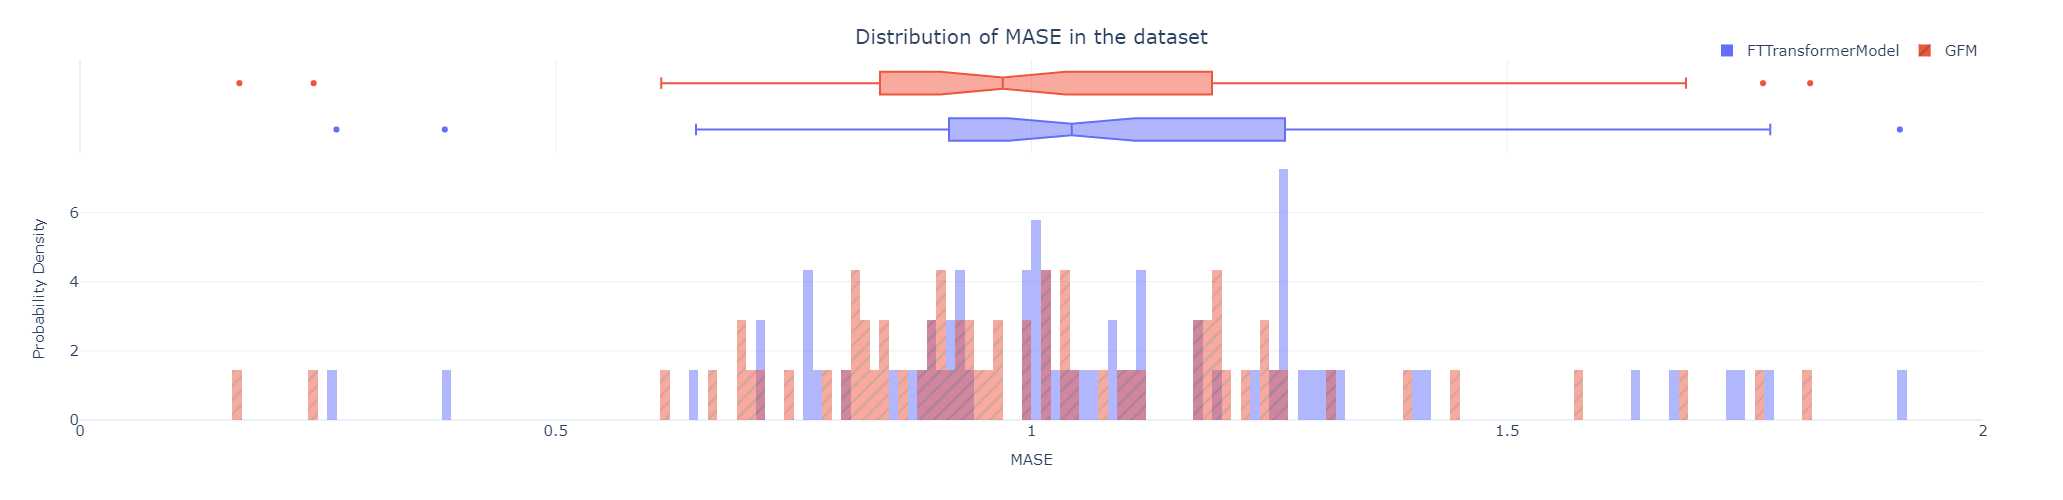

In [32]:
fig = px.histogram(metrics_df, 
                   x="MASE", 
                   color="Algorithm",
                   pattern_shape="Algorithm", 
                   marginal="box", 
                   nbins=500, 
                   barmode="overlay",
                   histnorm="probability density")
fig = format_plot(fig, xlabel="MASE", ylabel="Probability Density", title="Distribution of MASE in the dataset")
fig.update_layout(xaxis_range=[0,2])
# fig.write_image("imgs/chapter_12/ft_mase_dist.png")
fig.show()

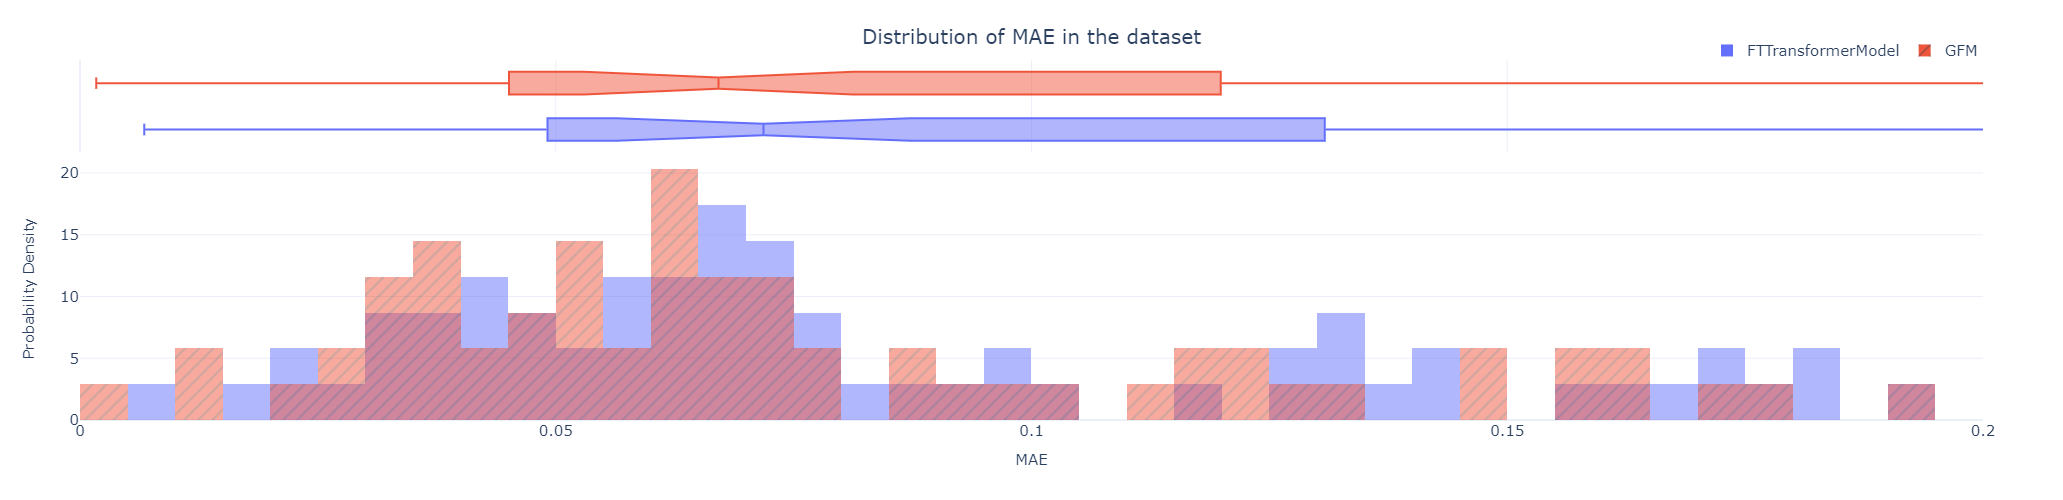

In [34]:
fig = px.histogram(metrics_df, 
                   x="MAE", 
                   color="Algorithm",
                   pattern_shape="Algorithm", 
                   marginal="box", 
                   nbins=100, 
                   barmode="overlay",
                   histnorm="probability density")
fig = format_plot(fig, xlabel="MAE", ylabel="Probability Density", title="Distribution of MAE in the dataset")
# fig.write_image("imgs/chapter_12/ft_mae_dist.png")
fig.update_layout(xaxis_range=[0,0.2])
fig.show()

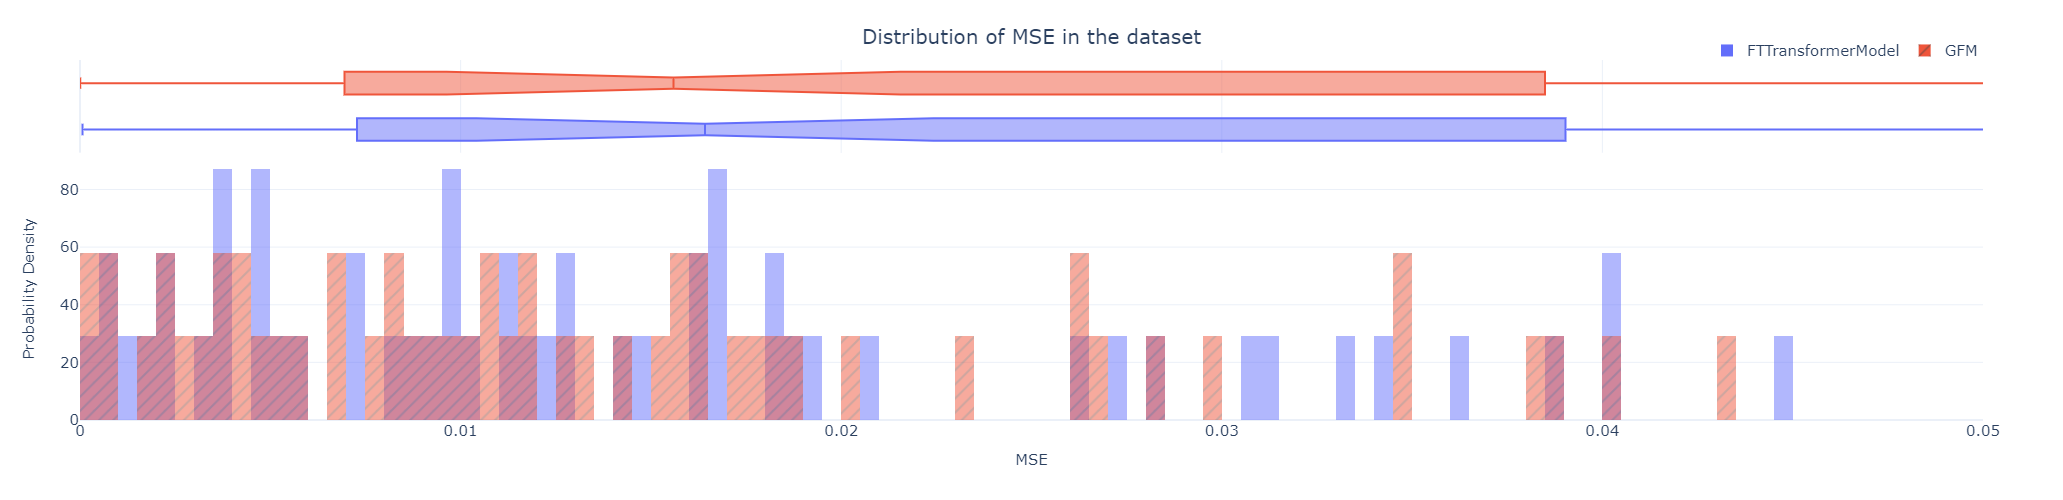

In [36]:
fig = px.histogram(metrics_df, 
                   x="MSE", 
                   color="Algorithm",
                   pattern_shape="Algorithm", 
                   marginal="box", 
                   nbins=500, 
                   barmode="overlay",
                   histnorm="probability density")
fig = format_plot(fig, xlabel="MSE", ylabel="Probability Density", title="Distribution of MSE in the dataset")
fig.update_layout(xaxis_range=[0,0.05])
# fig.write_image("imgs/chapter_12/ft_mse_dist.png")
fig.show()

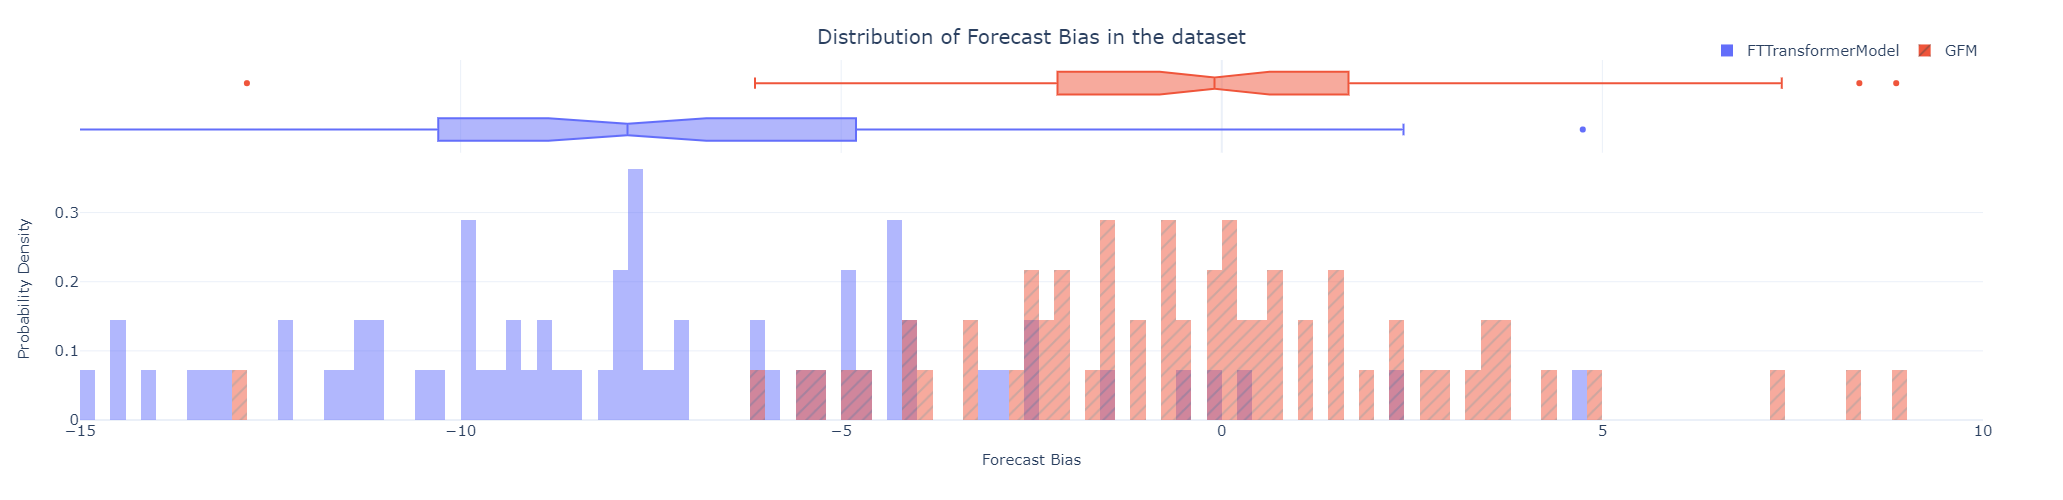

In [38]:
fig = px.histogram(metrics_df, 
                   x="Forecast Bias", 
                   color="Algorithm",
                   pattern_shape="Algorithm", 
                   marginal="box", 
                   nbins=250,
                   barmode="overlay",
                   histnorm="probability density")
fig = format_plot(fig, xlabel="Forecast Bias", ylabel="Probability Density", title="Distribution of Forecast Bias in the dataset")
fig.update_layout(xaxis_range=[-15,10])
# fig.write_image("imgs/chapter_12/ft_bias_dist.png")
fig.show()

# Saving the Forecasts and Metrics

In [35]:
os.makedirs("data/london_smart_meters/output", exist_ok=True)
output = Path("data/london_smart_meters/output")

In [45]:
pred_df.to_pickle(output/"ft_transformer_val_df.pkl")
metrics_df.to_pickle(output/"ft_transformer_metrics_val_df.pkl")
agg_metrics_df.to_pickle(output/"ft_transformer_aggregate_metrics_val.pkl")